In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import warnings
import scipy
import scipy.stats as scs

sys.path.append("../scripts/")
from clean_data import  DataCleaner
from utils import  Utils
from HypothesisPlot import  HypothesisPlot
from ABTestingFunctions import  ABTesting
warnings.filterwarnings("ignore")

In [4]:
cleaner= DataCleaner()
utils = Utils()
plotter = HypothesisPlot()
ab_testing = ABTesting()

In [5]:
df = utils.load_data("../data/AdSmartABdata.csv")
responsive_df = cleaner.drop_unresponsive(df)
responsive_df.shape

(1243, 9)

In [6]:
responsive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 2 to 8071
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1243 non-null   object
 1   experiment   1243 non-null   object
 2   date         1243 non-null   object
 3   hour         1243 non-null   int64 
 4   device_make  1243 non-null   object
 5   platform_os  1243 non-null   int64 
 6   browser      1243 non-null   object
 7   yes          1243 non-null   int64 
 8   no           1243 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 97.1+ KB


In [7]:
cleaned_df=responsive_df[['auction_id','experiment','yes']]
cleaned_df.rename(columns={'yes':'know_brand'},inplace=True)
cleaned_df.head()

,auction_id,experiment,know_brand
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,0


Data Summary

In [8]:
summary_df = cleaned_df.pivot_table( index='experiment')
summary_df

,know_brand
experiment,
control,0.450512
exposed,0.468798


In [9]:
summary_df = cleaned_df.pivot_table( index='experiment', aggfunc='sum')
summary_df['total'] = cleaned_df.pivot_table( index='experiment', aggfunc='count')[['auction_id']]
summary_df['rate'] = cleaned_df.pivot_table( index='experiment')
summary_df['not_know_brand'] = summary_df['total'] - summary_df['know_brand']
summary_df = summary_df.reindex(['know_brand', 'not_know_brand', 'total', 'rate'], axis=1)
summary_df

,know_brand,not_know_brand,total,rate
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [10]:
exp_rate = summary_df['rate']['exposed']
cont_rate = summary_df['rate']['control']

exp_aware = summary_df['know_brand']['exposed']
cont_aware = summary_df['know_brand']['control']

exp_total = summary_df['total']['exposed']
cont_total = summary_df['total']['control']

In [11]:
diff = exp_rate - cont_rate

In [12]:
print(f'The difference between conversion rates of the test and control groups is {diff}.')

The difference between conversion rates of the test and control groups is 0.018285619295484168.


Binomial Distribution

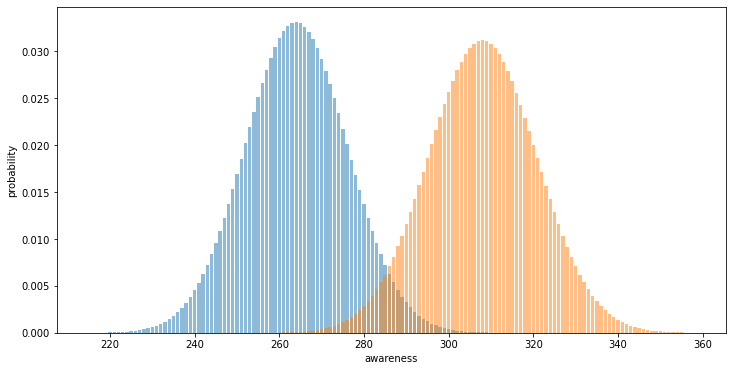

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

xC = np.linspace(cont_aware - 49, cont_aware + 50, 100)
yC = scs.binom(cont_total, cont_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')
xE = np.linspace(exp_aware - 49, exp_aware + 50, 100)
yE = scs.binom(exp_total , exp_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')
plt.xlabel('awareness')
plt.ylabel('probability')
plt.show()

Mean Distribution

In [14]:
# standard error of the mean
SE_C = np.sqrt(cont_rate * (1-cont_rate)) / np.sqrt(cont_total)
SE_E = np.sqrt(exp_rate * (1-exp_rate)) / np.sqrt(exp_total)

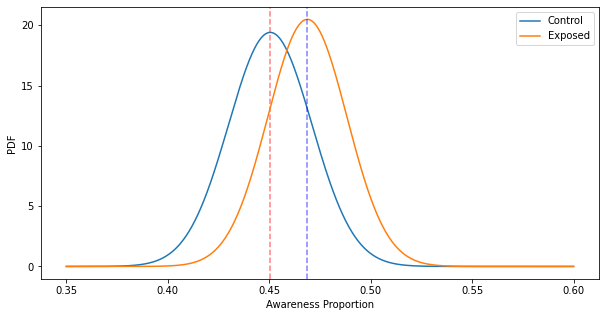

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(cont_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=cont_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exp_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.show()

As we can see from the above chart, the mean for exposed distribution is just .45 while mean value for the control distribution is around .47

In [16]:
std_cont = np.sqrt(cont_rate * (1 - cont_rate) / cont_total)
std_exp = np.sqrt(exp_rate * (1 - exp_rate) / exp_total)
std_cont, std_exp

(0.02055339057798332, 0.019468837373132736)

Null hypothesis and Alternative hypothesis

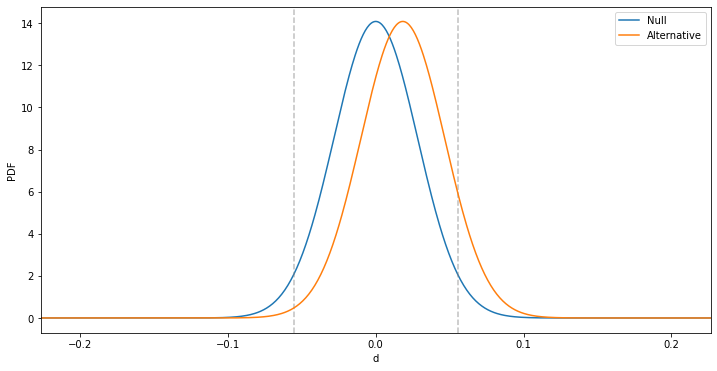

In [18]:
plotter.hypo_plot(cont_total, exp_total, cont_rate, diff)

In [19]:
z_score = (diff) / np.sqrt(std_cont**2 + std_exp**2)
p_value = scs.norm().sf(z_score)
z_score, p_value

(0.6458981015684259, 0.2591726745827285)